In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LassoCV, LogisticRegression, LogisticRegressionCV 
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (confusion_matrix, roc_curve, auc, classification_report, 
ConfusionMatrixDisplay, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay, PredictionErrorDisplay)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.utils.discovery import all_displays
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import LearningCurveDisplay, learning_curve
from sklearn.svm import SVC

from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier

from scipy.stats import fisher_exact

from yellowbrick.classifier import DiscriminationThreshold
from yellowbrick.classifier.threshold import discrimination_threshold

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import json

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(8090)

In [1]:
data = pd.read_csv('/Users/michael/Documents/MA Stats/STAT 8090/final dataset/full dataset.csv')
data['ipo_date'] = pd.to_datetime(data['ipo_date'])
data = data.sort_values(by='ipo_date')
data.head()

NameError: name 'pd' is not defined

In [4]:
# validation = pd.read_csv('/Users/michael/Documents/MA Stats/STAT 8090/final dataset/validation_set.csv')

In [5]:
with open('/Users/michael/Documents/MA Stats/STAT 8090/Code Files/exchange.json','r') as f:
    exchange = json.load(f)

In [6]:
with open('/Users/michael/Documents/MA Stats/STAT 8090/Code Files/sector.json','r') as f:
    sector = json.load(f)

In [7]:
with open('/Users/michael/Documents/MA Stats/STAT 8090/Code Files/industry.json','r') as f:
    industry = json.load(f)

In [8]:
data['Exchange'] = data['Exchange'].replace(exchange)
data['Sector'] = data['Sector'].replace(sector)
data['Industry'] = data['Industry'].replace(industry)

In [9]:
# validation['Exchange'] = validation['Exchange'].replace(exchange)
# validation['Sector'] = validation['Sector'].replace(sector)
# validation['Industry'] = validation['Industry'].replace(industry)

In [10]:
data = data.drop(columns=['Symbol', 'Company_Name', 'ipo_date', 'Country_HQ', 'Pitchbook_Number',
                          'Orig_Range_Low', 'Orig_Range_High', 'Year_Founded', 'Raised_to_IPO',
                          'ipo_date_open','ipo_date_close','ipo_date_volume','plusone_open','plusone_close',
                          'plusone_volume','plustwo_open','plustwo_close','plustwo_volume','plusthree_open','plusthree_close',
                          'plusthree_volume','plus90_open','plus90_close','plus90_volume','plus180_open','plus180_close',
                          'plus180_volume','day_one_bump','ipo_date_change_pct','ipo_date_volume_pct','plusone_change_pct',
                          'plusone_volume_pct','plustwo_change_pct','plustwo_volume_pct','plusthree_change_pct',
                          'plusthree_volume_pct','plus90_change_pct','plus90_volume_pct','plus180_change_pct','plus180_volume_pct',
                          'd1_d180', 'd1_d180_pre_price'])

In [11]:
# validation = validation.drop(columns=['Symbol', 'Company_Name', 'ipo_date', 'Country_HQ', 'Pitchbook_Number',
#                           'Orig_Range_Low', 'Orig_Range_High', 'Year_Founded', 'Raised_to_IPO',
#                           'ipo_date_open','ipo_date_close','ipo_date_volume','plusone_open','plusone_close',
#                           'plusone_volume','plustwo_open','plustwo_close','plustwo_volume','plusthree_open','plusthree_close',
#                           'plusthree_volume','plus90_open','plus90_close','plus90_volume','plus180_open','plus180_close',
#                           'plus180_volume','day_one_bump','ipo_date_change_pct','ipo_date_volume_pct','plusone_change_pct',
#                           'plusone_volume_pct','plustwo_change_pct','plustwo_volume_pct','plusthree_change_pct',
#                           'plusthree_volume_pct','plus90_change_pct','plus90_volume_pct','plus180_change_pct','plus180_volume_pct',
#                           'd1_d180', 'd1_d180_pre_price'])

In [12]:
data.head()

,Exchange,Price,Shares,Offer_Amount,IPO_Year,Years_to_IPO,Price_Low_Delta,Price_High_Delta,Sector,Industry,...,market_min5,market_min4,market_min3,market_min2,market_min1,market_min0,sent_negative,sent_neutral,sent_positive,d1_pop
0,1,11.0,9090910,100000010,2023,5,-0.153846,-0.266667,5,65,...,13463.77810,14033.09100,13739.49652,13585.84000,13199.42727,13913.16048,0,0,0,0
1,0,19.0,10000000,190000000,2023,8,0.000000,-0.095238,3,43,...,15230.52727,15560.37143,16104.99500,15980.94783,15786.03000,15149.39545,0,0,0,0
2,0,46.0,32258064,1483870944,2023,249,0.045455,-0.061224,1,13,...,15230.52727,15560.37143,16104.99500,15980.94783,15786.03000,15149.39545,2,1,0,0
3,0,30.0,19200000,576000000,2023,11,0.200000,0.111111,8,136,...,15507.15789,15230.52727,15560.37143,16104.99500,15980.94783,15786.03000,1,0,0,1
4,1,30.0,22000000,660000000,2023,11,0.153846,0.071429,1,17,...,12073.46421,12446.53000,13463.77810,14033.09100,13739.49652,13585.84000,1,1,0,1


In [13]:
X = data.drop(columns=['d1_pop'])
y = data['d1_pop']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8090)

unique_values = set(X_train['Industry'])

# Check if at least one sample from each unique value is present in the training set
for value in unique_values:
    if value not in X_train['Industry'].unique():
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8090)
        break

In [14]:
# X_valid = validation.drop(columns=['d1_pop'])
# y_valid = validation['d1_pop']

## Full Model

### Support Vector Machine

In [29]:
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('sampler', RandomUnderSampler()),
    ('classifier', SVC(gamma='auto', probability=True))
])

In [30]:
param_grid = {
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
    'classifier__degree': [1,3,5,7],
    'classifier__decision_function_shape': ['ovo', 'ovr'] 
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=10, verbose=2)

grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits
[CV] END classifier__decision_function_shape=ovo, classifier__degree=1, classifier__kernel=linear; total time=   0.1s
[CV] END classifier__decision_function_shape=ovo, classifier__degree=1, classifier__kernel=linear; total time=   0.1s
[CV] END classifier__decision_function_shape=ovo, classifier__degree=1, classifier__kernel=linear; total time=   0.1s
[CV] END classifier__decision_function_shape=ovo, classifier__degree=1, classifier__kernel=linear; total time=   0.1s
[CV] END classifier__decision_function_shape=ovo, classifier__degree=1, classifier__kernel=linear; total time=   0.1s
[CV] END classifier__decision_function_shape=ovo, classifier__degree=1, classifier__kernel=linear; total time=   0.1s
[CV] END classifier__decision_function_shape=ovo, classifier__degree=1, classifier__kernel=linear; total time=   0.1s
[CV] END classifier__decision_function_shape=ovo, classifier__degree=1, classifier__kernel=linear; total time= 

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('sampler', RandomUnderSampler()),
                                       ('classifier',
                                        SVC(gamma='auto', probability=True))]),
             param_grid={'classifier__decision_function_shape': ['ovo', 'ovr'],
                         'classifier__degree': [1, 3, 5, 7],
                         'classifier__kernel': ['linear', 'poly', 'rbf',
                                                'sigmoid', 'precomputed']},
             verbose=2)

In [31]:
ranks = pd.DataFrame(
    {
        'Model': grid_search.cv_results_['params'],
        'Mean Test Score': grid_search.cv_results_['mean_test_score'],
        'Std Test Score': grid_search.cv_results_['std_test_score'],
        'Rank': grid_search.cv_results_['rank_test_score']
    }
)

pd.concat([ranks.drop(['Model'], axis=1), ranks['Model'].apply(pd.Series)], axis=1).sort_values(by="Rank")

,Mean Test Score,Std Test Score,Rank,classifier__decision_function_shape,classifier__degree,classifier__kernel
26,0.648788,0.063101,1,ovr,3,poly
3,0.645219,0.069433,2,ovo,1,sigmoid
13,0.632357,0.083093,3,ovo,5,sigmoid
23,0.632323,0.051203,4,ovr,1,sigmoid
18,0.630303,0.079029,5,ovo,7,sigmoid
21,0.630269,0.102238,6,ovr,1,poly
2,0.628586,0.062981,7,ovo,1,rbf
28,0.624882,0.048659,8,ovr,3,sigmoid
6,0.621212,0.083353,9,ovo,3,poly
38,0.619394,0.065603,10,ovr,7,sigmoid


In [32]:
best_estimator = grid_search.best_estimator_

print("Best Estimator:", best_estimator)

Best Estimator: Pipeline(steps=[('scaler', StandardScaler()), ('sampler', RandomUnderSampler()),
                ('classifier',
                 SVC(gamma='auto', kernel='poly', probability=True))])


In [33]:
y_pred = grid_search.best_estimator_.predict(X_test)

In [34]:
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
cm

Confusion Matrix:


array([[51, 26],
       [63, 92]])

In [35]:
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

odds_ratio, p_value = fisher_exact([[TP, FP], [FN, TN]])

log_odds_ratio = np.log(odds_ratio)

std_error_log_odds_ratio = np.sqrt(1/TP + 1/FP + 1/FN + 1/TN)

z_score = 1.96  # 95% confidence interval
lower_bound = log_odds_ratio - z_score * std_error_log_odds_ratio
upper_bound = log_odds_ratio + z_score * std_error_log_odds_ratio


ci_lower = np.exp(lower_bound)
ci_upper = np.exp(upper_bound)

print("95% Confidence Interval for Odds Ratio:", (ci_lower, ci_upper))
print("p-value for Odds Ratio:", p_value)

95% Confidence Interval for Odds Ratio: (1.6186331734473947, 5.069204072987086)
p-value for Odds Ratio: 0.00028013209629505775


In [36]:
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.66      0.53        77
           1       0.78      0.59      0.67       155

    accuracy                           0.62       232
   macro avg       0.61      0.63      0.60       232
weighted avg       0.67      0.62      0.63       232



In [37]:
# y_pred = grid_search.best_estimator_.predict(X_valid)

In [38]:
# y_pred

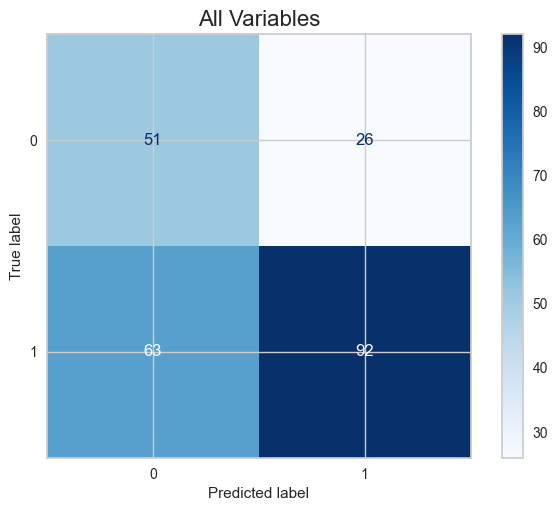

In [39]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_estimator.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('All Variables', fontsize=16)
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/cm_svm_full_1.png', dpi=300, bbox_inches="tight")
plt.show()

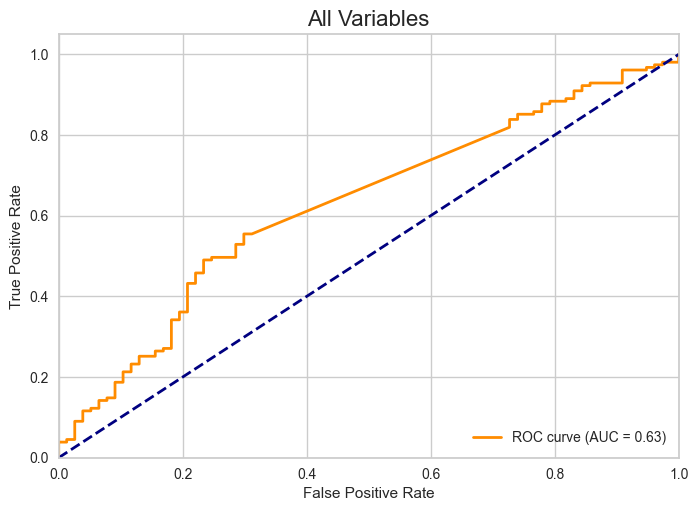

In [40]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, best_estimator.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('All Variables', fontsize=16)
plt.legend(loc="lower right")
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/roc_svm_full_1.png', dpi=300, bbox_inches="tight")
plt.show()

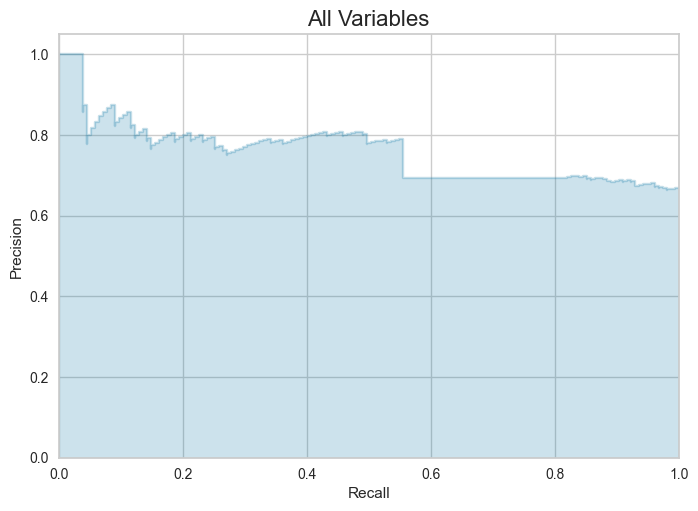

In [41]:
# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, best_estimator.predict_proba(X_test)[:, 1])

# Plot Precision-Recall curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('All Variables', fontsize=16)
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/prc_svm_full_1.png', dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# train_sizes, train_scores, test_scores = learning_curve(best_estimator, X, y)
# display = LearningCurveDisplay(train_sizes=train_sizes,
#                                train_scores=train_scores, test_scores=test_scores, score_name="accuracy")
# display.plot()
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
# plt.title('Learning Curve')
# plt.show()

In [ ]:
# scaler = StandardScaler()

# X_test_std = scaler.fit_transform(X_test)
# # Yellowbrick plot
# visualizer = DiscriminationThreshold(best_estimator)

# visualizer.fit(X_test_std, y_test)
# visualizer.show()

In [ ]:
## alt. Yellowbrick model
#discrimination_threshold(best_estimator, X_test_std, y_test)

## Reduced Models

Lasso Regression is used to build the reduced model, with fewer predictor variables. This model will compared to the full model. 

### Lasso Regression and Decision Tree

In [42]:
lasso_decision_tree = Pipeline([
    ('scaler', StandardScaler()),
    ('sampler', RandomUnderSampler()),
    ('feature_selection', SelectFromModel(LogisticRegression(penalty="l1", solver='liblinear'))), 
    ('classifier', SVC(gamma='auto', probability=True))
])

In [43]:
param_grid = {
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
    'classifier__degree': [1,3,5,7],
    'classifier__decision_function_shape': ['ovo', 'ovr']
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=10, verbose=2)

grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits
[CV] END classifier__decision_function_shape=ovo, classifier__degree=1, classifier__kernel=linear; total time=   0.1s
[CV] END classifier__decision_function_shape=ovo, classifier__degree=1, classifier__kernel=linear; total time=   0.1s
[CV] END classifier__decision_function_shape=ovo, classifier__degree=1, classifier__kernel=linear; total time=   0.1s
[CV] END classifier__decision_function_shape=ovo, classifier__degree=1, classifier__kernel=linear; total time=   0.1s
[CV] END classifier__decision_function_shape=ovo, classifier__degree=1, classifier__kernel=linear; total time=   0.1s
[CV] END classifier__decision_function_shape=ovo, classifier__degree=1, classifier__kernel=linear; total time=   0.1s
[CV] END classifier__decision_function_shape=ovo, classifier__degree=1, classifier__kernel=linear; total time=   0.1s
[CV] END classifier__decision_function_shape=ovo, classifier__degree=1, classifier__kernel=linear; total time= 

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('sampler', RandomUnderSampler()),
                                       ('classifier',
                                        SVC(gamma='auto', probability=True))]),
             param_grid={'classifier__decision_function_shape': ['ovo', 'ovr'],
                         'classifier__degree': [1, 3, 5, 7],
                         'classifier__kernel': ['linear', 'poly', 'rbf',
                                                'sigmoid', 'precomputed']},
             verbose=2)

In [44]:
best_estimator = grid_search.best_estimator_

print("Best Estimator:", best_estimator)

Best Estimator: Pipeline(steps=[('scaler', StandardScaler()), ('sampler', RandomUnderSampler()),
                ('classifier',
                 SVC(degree=1, gamma='auto', kernel='poly', probability=True))])


In [45]:
ranks = pd.DataFrame(
    {
        'Model': grid_search.cv_results_['params'],
        'Mean Test Score': grid_search.cv_results_['mean_test_score'],
        'Std Test Score': grid_search.cv_results_['std_test_score'],
        'Rank': grid_search.cv_results_['rank_test_score']
    }
)

pd.concat([ranks.drop(['Model'], axis=1), ranks['Model'].apply(pd.Series)], axis=1).sort_values(by="Rank")

,Mean Test Score,Std Test Score,Rank,classifier__decision_function_shape,classifier__degree,classifier__kernel
21,0.656229,0.044406,1,ovr,1,poly
33,0.639663,0.060215,2,ovr,5,sigmoid
28,0.638114,0.110535,3,ovr,3,sigmoid
13,0.630404,0.067700,4,ovo,5,sigmoid
26,0.628653,0.091385,5,ovr,3,poly
38,0.626734,0.075554,6,ovr,7,sigmoid
8,0.624882,0.044229,7,ovo,3,sigmoid
23,0.624848,0.073609,8,ovr,1,sigmoid
6,0.623098,0.093570,9,ovo,3,poly
1,0.623030,0.087141,10,ovo,1,poly


In [46]:
y_pred = grid_search.best_estimator_.predict(X_test)

In [47]:
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
cm

Confusion Matrix:


array([[ 49,  28],
       [ 44, 111]])

In [48]:
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

odds_ratio, p_value = fisher_exact([[TP, FP], [FN, TN]])

log_odds_ratio = np.log(odds_ratio)

std_error_log_odds_ratio = np.sqrt(1/TP + 1/FP + 1/FN + 1/TN)

z_score = 1.96  # 95% confidence interval
lower_bound = log_odds_ratio - z_score * std_error_log_odds_ratio
upper_bound = log_odds_ratio + z_score * std_error_log_odds_ratio


ci_lower = np.exp(lower_bound)
ci_upper = np.exp(upper_bound)

print("95% Confidence Interval for Odds Ratio:", (ci_lower, ci_upper))
print("p-value for Odds Ratio:", p_value)

95% Confidence Interval for Odds Ratio: (2.4694446212919723, 7.89255125035933)
p-value for Odds Ratio: 4.3449798089255156e-07


In [49]:
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.64      0.58        77
           1       0.80      0.72      0.76       155

    accuracy                           0.69       232
   macro avg       0.66      0.68      0.67       232
weighted avg       0.71      0.69      0.70       232



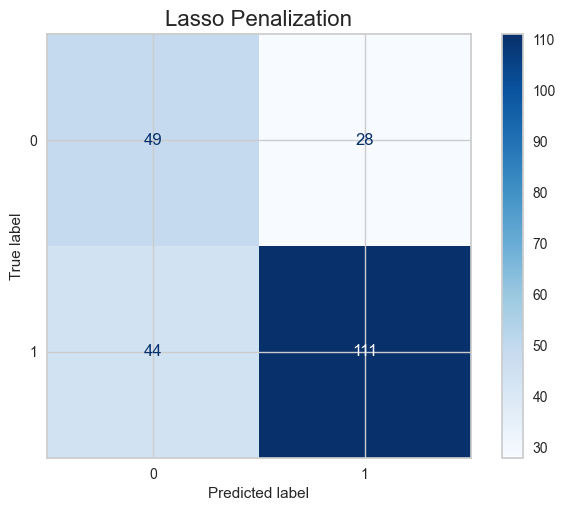

In [50]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_estimator.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Lasso Penalization', fontsize=16)
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/cm_svm_red1_1.png', dpi=300, bbox_inches="tight")
plt.show()

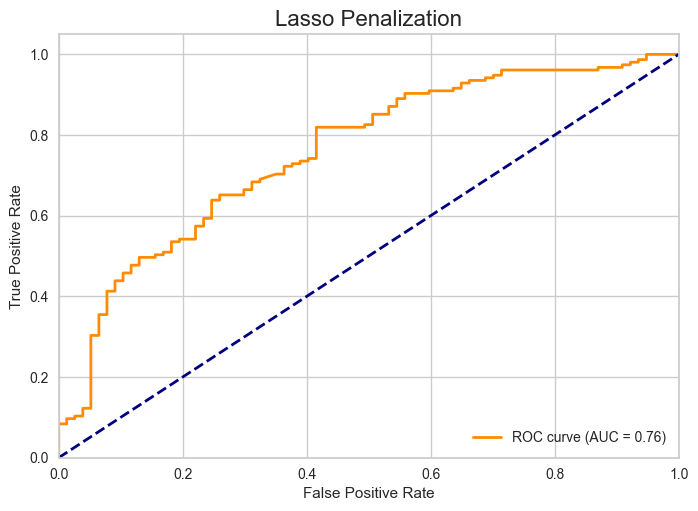

In [51]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, best_estimator.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Lasso Penalization', fontsize=16)
plt.legend(loc="lower right")
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/roc_svm_red1_1.png', dpi=300, bbox_inches="tight")
plt.show()

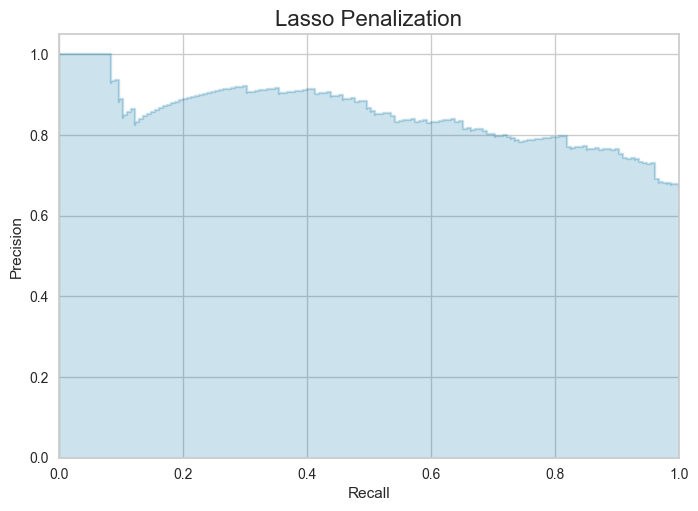

In [52]:
# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, best_estimator.predict_proba(X_test)[:, 1])

# Plot Precision-Recall curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Lasso Penalization', fontsize=16)
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/prc_svm_red1_1.png', dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# train_sizes, train_scores, test_scores = learning_curve(best_estimator, X, y)
# display = LearningCurveDisplay(train_sizes=train_sizes,
#                                train_scores=train_scores, test_scores=test_scores, score_name="accuracy")
# display.plot()
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
# plt.title('Learning Curve')
# plt.show()

## Feature Importance Models and Base Line Models

In [53]:
model = RandomForestClassifier()
model.fit(X, y)

feature_importance = pd.DataFrame(model.feature_importances_,
                                   index=X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

In [54]:
fi = feature_importance[feature_importance['importance'] >= 0.01]
fi = fi.index.tolist()

In [55]:
fi_data = X[fi]

In [56]:
fi_data.head()

,Price_High_Delta,Price_Low_Delta,raise_to_ipo_ratio,Offer_Amount,Shares,Years_to_IPO,Price,Venture Capital,90_Trailing_IPO_plus95,completed_rounds_to_ipo,...,market_min1,number_of_bookrunners,cancelled_rounds,market_min4,market_min2,market_min5,market_min0,market_min3,Growth/Expansion,retail_sales_min2
0,-0.266667,-0.153846,0.337223,100000010,9090910,5,11.0,8,11,6,...,13199.42727,5,0,14033.09100,13585.84000,13463.77810,13913.16048,13739.49652,0,612633
1,-0.095238,0.000000,1.000000,190000000,10000000,8,19.0,0,12,4,...,15786.03000,5,0,15560.37143,15980.94783,15230.52727,15149.39545,16104.99500,0,608386
2,-0.061224,0.045455,2.087695,1483870944,32258064,249,46.0,0,14,6,...,15786.03000,11,0,15560.37143,15980.94783,15230.52727,15149.39545,16104.99500,0,608386
3,0.111111,0.200000,0.514286,576000000,19200000,11,30.0,21,16,8,...,15980.94783,8,0,15230.52727,16104.99500,15507.15789,15786.03000,15560.37143,10,603792
4,0.071429,0.153846,0.212219,660000000,22000000,11,30.0,97,15,17,...,13739.49652,5,2,12446.53000,14033.09100,12073.46421,13585.84000,13463.77810,9,603792


In [57]:
X_train, X_test, y_train, y_test = train_test_split(fi_data, y, test_size=0.3, random_state=8090)

unique_values = set(X_train['Industry'])

# Check if at least one sample from each unique value is present in the training set
for value in unique_values:
    if value not in X_train['Industry'].unique():
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8090)
        break

In [58]:
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('sampler', RandomUnderSampler()),
    ('classifier', SVC(gamma='auto', probability=True))
])

In [59]:
param_grid = {
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
    'classifier__degree': [1,3,5,7],
    'classifier__decision_function_shape': ['ovo', 'ovr']
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=10, verbose=2)

grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits
[CV] END classifier__decision_function_shape=ovo, classifier__degree=1, classifier__kernel=linear; total time=   0.0s
[CV] END classifier__decision_function_shape=ovo, classifier__degree=1, classifier__kernel=linear; total time=   0.0s
[CV] END classifier__decision_function_shape=ovo, classifier__degree=1, classifier__kernel=linear; total time=   0.0s
[CV] END classifier__decision_function_shape=ovo, classifier__degree=1, classifier__kernel=linear; total time=   0.0s
[CV] END classifier__decision_function_shape=ovo, classifier__degree=1, classifier__kernel=linear; total time=   0.0s
[CV] END classifier__decision_function_shape=ovo, classifier__degree=1, classifier__kernel=linear; total time=   0.0s
[CV] END classifier__decision_function_shape=ovo, classifier__degree=1, classifier__kernel=linear; total time=   0.0s
[CV] END classifier__decision_function_shape=ovo, classifier__degree=1, classifier__kernel=linear; total time= 

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('sampler', RandomUnderSampler()),
                                       ('classifier',
                                        SVC(gamma='auto', probability=True))]),
             param_grid={'classifier__decision_function_shape': ['ovo', 'ovr'],
                         'classifier__degree': [1, 3, 5, 7],
                         'classifier__kernel': ['linear', 'poly', 'rbf',
                                                'sigmoid', 'precomputed']},
             verbose=2)

In [60]:
ranks = pd.DataFrame(
    {
        'Model': grid_search.cv_results_['params'],
        'Mean Test Score': grid_search.cv_results_['mean_test_score'],
        'Std Test Score': grid_search.cv_results_['std_test_score'],
        'Rank': grid_search.cv_results_['rank_test_score']
    }
)

pd.concat([ranks.drop(['Model'], axis=1), ranks['Model'].apply(pd.Series)], axis=1).sort_values(by="Rank")

,Mean Test Score,Std Test Score,Rank,classifier__decision_function_shape,classifier__degree,classifier__kernel
21,0.697037,0.057397,1,ovr,1,poly
6,0.693266,0.072209,2,ovo,3,poly
1,0.691414,0.049628,3,ovo,1,poly
36,0.689562,0.067126,4,ovr,7,poly
11,0.684074,0.063915,5,ovo,5,poly
16,0.682155,0.069705,6,ovo,7,poly
31,0.680303,0.079058,7,ovr,5,poly
15,0.676566,0.050230,8,ovo,7,linear
3,0.674882,0.064943,9,ovo,1,sigmoid
35,0.669360,0.086984,10,ovr,7,linear


In [61]:
best_estimator = grid_search.best_estimator_

print("Best Estimator:", best_estimator)

Best Estimator: Pipeline(steps=[('scaler', StandardScaler()), ('sampler', RandomUnderSampler()),
                ('classifier',
                 SVC(degree=1, gamma='auto', kernel='poly', probability=True))])


In [62]:
y_pred = grid_search.best_estimator_.predict(X_test)

In [63]:
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
cm

Confusion Matrix:


array([[ 48,  29],
       [ 38, 117]])

In [64]:
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

odds_ratio, p_value = fisher_exact([[TP, FP], [FN, TN]])

log_odds_ratio = np.log(odds_ratio)

std_error_log_odds_ratio = np.sqrt(1/TP + 1/FP + 1/FN + 1/TN)

z_score = 1.96  # 95% confidence interval
lower_bound = log_odds_ratio - z_score * std_error_log_odds_ratio
upper_bound = log_odds_ratio + z_score * std_error_log_odds_ratio


ci_lower = np.exp(lower_bound)
ci_upper = np.exp(upper_bound)

print("95% Confidence Interval for Odds Ratio:", (ci_lower, ci_upper))
print("p-value for Odds Ratio:", p_value)

95% Confidence Interval for Odds Ratio: (2.8289592056977417, 9.180457498360608)
p-value for Odds Ratio: 2.937785270514574e-08


In [65]:
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.62      0.59        77
           1       0.80      0.75      0.78       155

    accuracy                           0.71       232
   macro avg       0.68      0.69      0.68       232
weighted avg       0.72      0.71      0.71       232



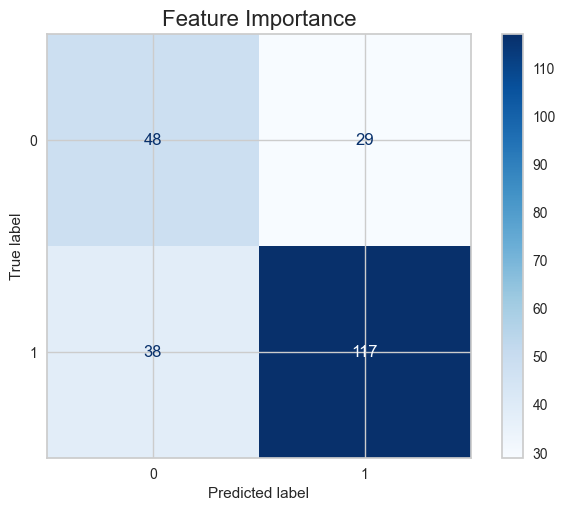

In [66]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_estimator.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Feature Importance', fontsize=16)
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/cm_svm_fi_1.png', dpi=300, bbox_inches="tight")
plt.show()

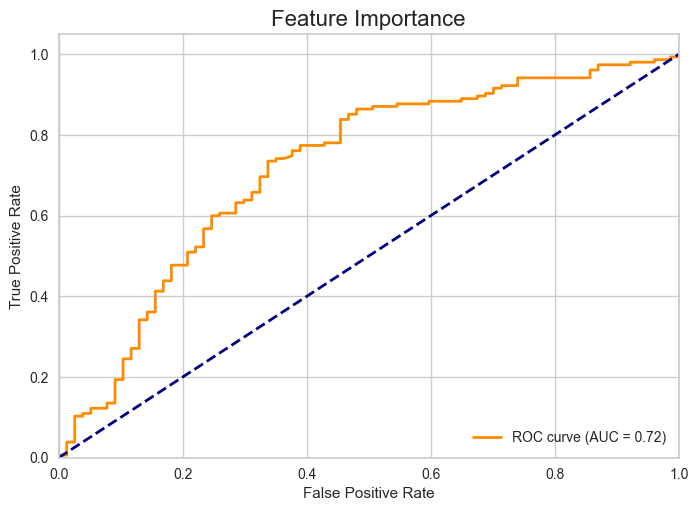

In [67]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, best_estimator.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Feature Importance', fontsize=16)
plt.legend(loc="lower right")
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/roc_svm_fi_1.png', dpi=300, bbox_inches="tight")
plt.show()

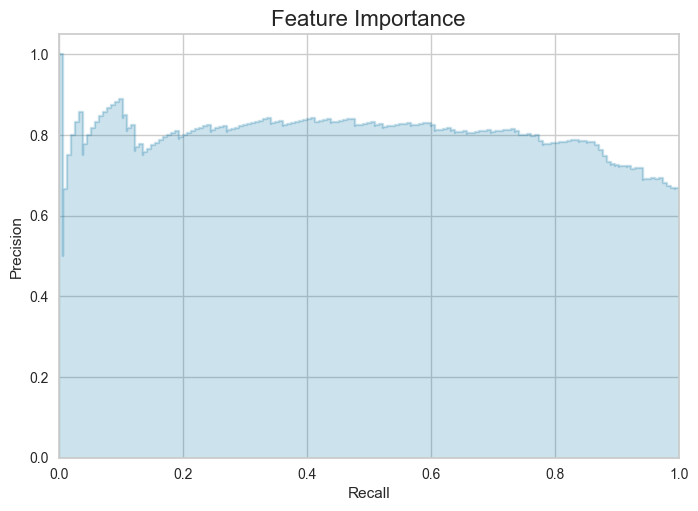

In [68]:
# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, best_estimator.predict_proba(X_test)[:, 1])

# Plot Precision-Recall curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Feature Importance', fontsize=16)
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/prc_svm_fi_1.png', dpi=300, bbox_inches="tight")
plt.show()

---
### End of Notebook